In [29]:
# 필요한 모듈 불러오기
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [30]:
# 데이터 로드 및 전처리 함수 정의
file_path = 'wine_review.csv'
wine_data = pd.read_csv(file_path)

# 리뷰 점수와 텍스트의 결측값 제거
wine_data = wine_data.dropna(subset=['reviews.rating', 'reviews.text'])

# 리뷰 점수를 감정으로 매핑
rating_mapping = {1: 'Strong Negative', 2: 'Weak Negative', 3: 'Neutral', 4: 'Positive', 5: 'Strong Positive'}
wine_data['sentiment'] = wine_data['reviews.rating'].map(rating_mapping)


In [31]:

# 텍스트 전처리 함수 정의
def preprocess_text(text):
    # 소문자로 변환
    text = text.lower()
    # 특수문자 제거
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # 토큰화
    words = text.split()
    # 불용어 제거
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    # 표제어 추출
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

In [32]:
# 모든 리뷰 텍스트에 전처리 적용
wine_data['cleaned_text'] = wine_data['reviews.text'].apply(preprocess_text)

# 특성 및 레이블 설정
X = wine_data['cleaned_text']
y = wine_data['sentiment']

# 데이터 분할 (훈련/테스트 세트)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [33]:
# 텍스트 데이터 벡터화
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [34]:
# 로지스틱 회귀 모델 학습 및 하이퍼파라미터 튜닝
model = LogisticRegression(max_iter=1000)
param_grid = {'C': [0.1, 1, 10, 100]}
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_vec, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': [0.1, 1, 10, 100]}, scoring='accuracy')

In [35]:
# 최적 모델 선택
best_model = grid_search.best_estimator_

In [36]:
# 교차 검증을 통한 성능 평가
cv_accuracy = cross_val_score(best_model, vectorizer.transform(X), y, cv=5, scoring='accuracy')
cv_precision = cross_val_score(best_model, vectorizer.transform(X), y, cv=5, scoring='precision_weighted')
cv_recall = cross_val_score(best_model, vectorizer.transform(X), y, cv=5, scoring='recall_weighted')
cv_f1 = cross_val_score(best_model, vectorizer.transform(X), y, cv=5, scoring='f1_weighted')

print(f"Cross-Validated Accuracy: {cv_accuracy.mean()} (+/- {cv_accuracy.std() * 2})")
print(f"Cross-Validated Precision: {cv_precision.mean()} (+/- {cv_precision.std() * 2})")
print(f"Cross-Validated Recall: {cv_recall.mean()} (+/- {cv_recall.std() * 2})")
print(f"Cross-Validated F1 Score: {cv_f1.mean()} (+/- {cv_f1.std() * 2})")


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Cross-Validated Accuracy: 0.8359230949746891 (+/- 0.006702453547038448)
Cross-Validated Precision: 0.7431112370975184 (+/- 0.05291793598363097)
Cross-Validated Recall: 0.8359230949746891 (+/- 0.006702453547038448)
Cross-Validated F1 Score: 0.7705730785007151 (+/- 0.008447608075398306)


In [37]:
# 모델 평가
y_pred = best_model.predict(X_test_vec)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
roc_auc = roc_auc_score(label_binarize(y_test, classes=best_model.classes_), best_model.predict_proba(X_test_vec), multi_class='ovr')

# 결과 출력
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC AUC Score: {roc_auc}")


Accuracy: 0.8650306748466258
Precision: 0.8141061690524882
Recall: 0.8650306748466258
F1 Score: 0.8151763016430865
ROC AUC Score: 0.8449611349876361


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


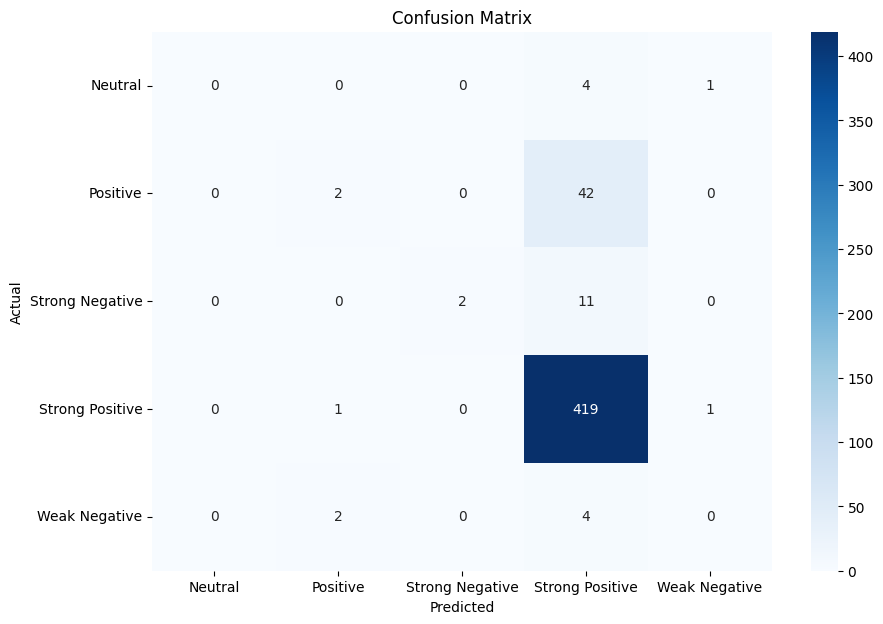

In [38]:
# 혼동 행렬 시각화
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


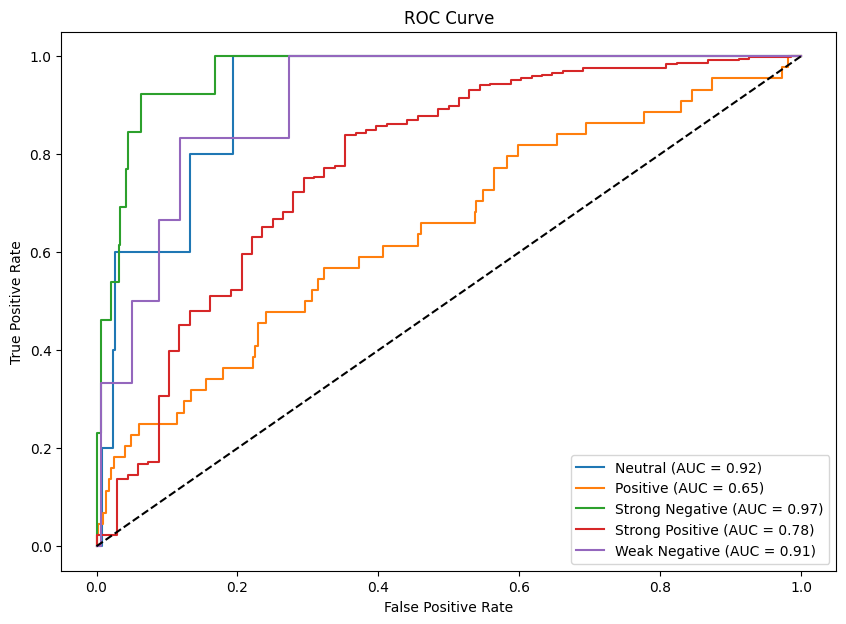

In [39]:
# ROC 곡선 시각화
y_test_binarized = label_binarize(y_test, classes=best_model.classes_)
plt.figure(figsize=(10, 7))
for i, sentiment in enumerate(best_model.classes_):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], best_model.predict_proba(X_test_vec)[:, i])
    plt.plot(fpr, tpr, label=f"{sentiment} (AUC = {roc_auc_score(y_test_binarized[:, i], best_model.predict_proba(X_test_vec)[:, i]):.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()